<h1><b>Question 1</b></h1>

First we will import relevant libraries for data analysis and visualization.

In [323]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [324]:
property_data= pd.read_csv('Q1_property.csv', sep= None) # sep is used for delimiter
property_data.head() # displaying the data

<ipython-input-324-4a58b71f9c33>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  property_data= pd.read_csv('Q1_property.csv', sep= None) # sep is used for delimiter


,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent
0,347795,8,https://www.zameen.com/Property/lahore_model_t...,House,220000000,Model Town,Lahore,Punjab,31.483869,74.325686,0.0,6 Kanal,For Sale,0.0,07-17-2019,Real Biz International,Usama Khan
1,482892,48,https://www.zameen.com/Property/lahore_multan_...,House,40000000,Multan Road,Lahore,Punjab,31.431593,74.179980,5.0,1 Kanal,For Sale,5.0,10-06-2018,Khan Estate,mohsinkhan and B
2,555962,75,https://www.zameen.com/Property/eden_eden_aven...,House,9500000,Eden,Lahore,Punjab,31.499348,74.416959,0.0,9 Marla,For Sale,3.0,07-03-2019,Shahum Estate 2,"Babar Hameed, Raja Omar"
3,562843,3821,https://www.zameen.com/Property/gulberg_2_gulb...,House,125000000,Gulberg,Lahore,Punjab,31.522069,74.355512,7.0,1 Kanal,For Sale,8.0,04-04-2019,NaN,NaN
4,686990,3522,https://www.zameen.com/Property/allama_iqbal_t...,House,21000000,Allama Iqbal Town,Lahore,Punjab,31.506483,74.286017,5.0,11 Marla,For Sale,6.0,04-04-2019,NaN,NaN


Now, we will select the city to work on.

In [325]:
property_data['city'].unique() # returns the cities in dataset

array(['Lahore', 'Karachi', 'Islamabad', 'Faisalabad', 'Rawalpindi', nan],
      dtype=object)

**Islamabad** will be the focal point for our analysis.

**Data Pre-Processing**

In [326]:
islamabad_dataset= property_data[property_data['city'] == 'Islamabad'] # creating another dataframe with the concerned city
islamabad_dataset= islamabad_dataset.reset_index()
islamabad_dataset= islamabad_dataset.drop('index', axis= 1)

In [327]:
islamabad_dataset.head()

,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent
0,237062,3325,https://www.zameen.com/Property/g_10_g_10_2_gr...,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2.0,4 Marla,For Sale,2.0,02-04-2019,NaN,NaN
1,346905,3236,https://www.zameen.com/Property/e_11_2_service...,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3.0,5.6 Marla,For Sale,3.0,05-04-2019,NaN,NaN
2,386513,764,https://www.zameen.com/Property/islamabad_g_15...,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6.0,8 Marla,For Sale,5.0,07-17-2019,NaN,NaN
3,592183,162,https://www.zameen.com/Property/islamabad_f_10...,House,70000000,F-10,Islamabad,Islamabad Capital,33.691531,73.005431,6.0,1.5 Kanal,For Sale,6.0,07-22-2019,Accurate Property,Accurate property
4,656161,340,https://www.zameen.com/Property/islamabad_bani...,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4.0,2 Kanal,For Sale,4.0,04-05-2019,NaN,NaN


In [328]:
islamabad_dataset.dtypes

property_id        int64
location_id        int64
page_url          object
property_type     object
price              int64
location          object
city              object
province_name     object
latitude         float64
longitude        float64
baths            float64
area              object
purpose           object
bedrooms         float64
date_added        object
agency            object
agent             object
dtype: object

In [329]:
islamabad_dataset.isna().sum() # missing values in dataset

property_id         0
location_id         0
page_url            0
property_type       0
price               0
location            0
city                0
province_name       0
latitude            0
longitude           0
baths               0
area                0
purpose             0
bedrooms            0
date_added          0
agency           9137
agent            9137
dtype: int64

In [330]:
islamabad_dataset.dropna(inplace= True) # dropping records with missing values

In [331]:
def deleteOutliers(dataframe, columns):
    for column in columns:
        lower_quartile= dataframe[column].quantile(0.25)
        upper_quartile= dataframe[column].quantile(0.75)
        inter_quartile_range= upper_quartile - lower_quartile
        lower_boundary= lower_quartile - 1.5 * inter_quartile_range
        upper_boundary= upper_quartile + 1.5 * inter_quartile_range
        # remove values under 100000 and the outlier rows
        dataframe = dataframe.loc[
            (dataframe[column] >= 100000) &
            (dataframe[column] >= lower_boundary) &
            (dataframe[column] <= upper_boundary)
        ]
    return dataframe
islamabad_dataset= deleteOutliers(islamabad_dataset, ['price'])
# dropping rows where 'purpose' is rent, as it creates erroneous values
islamabad_dataset= islamabad_dataset[islamabad_dataset['purpose'] != 'For Rent']

In [332]:
# dropping those property records which have no bathrooms or bedrooms
islamabad_dataset.drop(islamabad_dataset[(islamabad_dataset['bedrooms'] == 0) | (islamabad_dataset['baths'] == 0)].index, inplace=True)

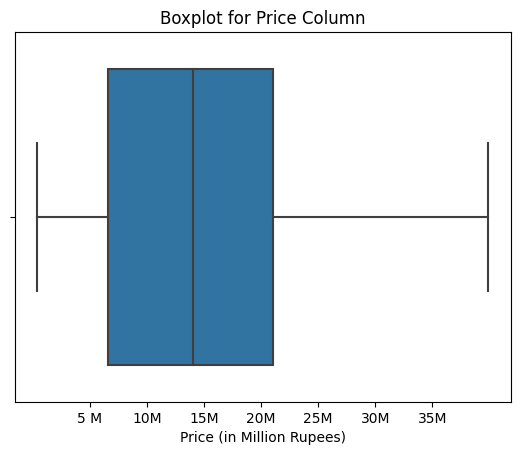

Minimum Price: 400000
Maximum Price: 39900000
Median Price: 14000000.0
Lower Quartile (25th Percentile): 6600000.0
Upper Quartile (75th Percentile): 21000000.0


In [333]:
sns.boxplot(x= islamabad_dataset['price'])
# setting custom tick locations and labels for the x-axis
tick_locations= [5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, ]
tick_labels= ['5 M', '10M', '15M', '20M', '25M', '30M', '35M']
plt.xticks(tick_locations, tick_labels)
# labels and title
plt.title('Boxplot for Price Column')
plt.xlabel('Price (in Million Rupees)')
plt.show()
price_column= islamabad_dataset['price']
# statistics(five number summary)
minimum_price= price_column.min()
maximum_price= price_column.max()
median_price= price_column.median()
lower_quartile_price= price_column.quantile(0.25)
upper_quartile_price= price_column.quantile(0.75)
print(f"Minimum Price: {minimum_price}")
print(f"Maximum Price: {maximum_price}")
print(f"Median Price: {median_price}")
print(f"Lower Quartile (25th Percentile): {lower_quartile_price}")
print(f"Upper Quartile (75th Percentile): {upper_quartile_price}")

**Exploratory Data Analysis(EDA)**

In [334]:
# eliminating unnecessary columns
column_names= ['location_id', 'page_url', 'province_name', 'latitude', 'longitude', 'property_id', 'purpose']
islamabad_dataset= islamabad_dataset.drop(column_names, axis= 1)

In [335]:
# correlation between variables
correlation_matrix= islamabad_dataset.corr()
correlation_matrix

<ipython-input-335-ee89bcc97a3c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix= islamabad_dataset.corr()


,price,baths,bedrooms
price,1.000000,0.656256,0.677367
baths,0.656256,1.000000,0.927745
bedrooms,0.677367,0.927745,1.000000


In [336]:
# grouping data by agencies and finding total properties listed by each agency
group_agency= islamabad_dataset.groupby('agency')
properties_listed= group_agency['price'].count()
properties_listed

agency
1 One Enterprises                            6
11 Estate & Builders                         1
4 Season Real Estate                         9
4M Enterprises                              49
7 Estate & Builders                          4
                                            ..
Zia Real Estate                             81
Ziyam Properties                            10
Zmaka Estate (Land Management Solutions)     1
Zone 2 Property Links                        3
Zulfiqar Enterprises                         6
Name: price, Length: 979, dtype: int64

In [337]:
# finding average property price for each agency
average_price= group_agency['price'].mean()

In [338]:
correlation= properties_listed.corr(average_price)
correlation

-0.06467549435661914

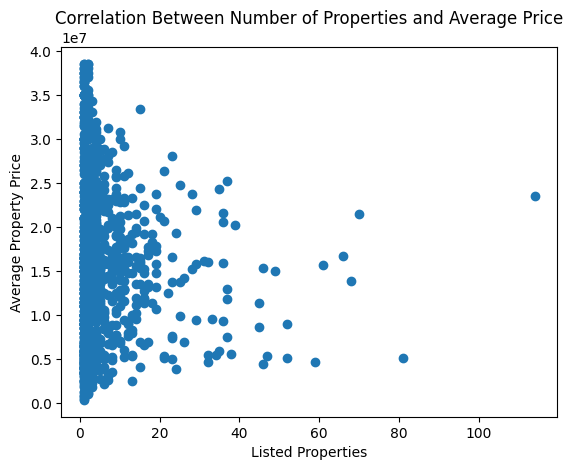

In [339]:
# scatterplot to show correlation
plt.scatter(properties_listed, average_price)
plt.xlabel('Listed Properties')
plt.ylabel('Average Property Price')
plt.title('Correlation Between Number of Properties and Average Price')
plt.show()

According to my assumption, a negative correlation(weak) indicates that the as the number of properties listed increased, it had an impact on average prices. However, such a weak correlation can also be neglected.

In [340]:
# finding out which agency listed the most and least properties
print(properties_listed.idxmax(),'listed', properties_listed.max(), 'properties.')
print(properties_listed.idxmin(),'listed', properties_listed.min(), 'properties.')

Foothills Real Estate & Developers listed 114 properties.
11 Estate & Builders listed 1 properties.


**Feature Engineering**

In [341]:
# converting area to sq_mtr
def convert_to_sq_meter(area):
    area= str(area)
    if 'Marla' in area:
        area = float(re.sub(r'\D+', '', area)) * 25.2929
    elif 'Kanal' in area:
        area = float(re.sub(r'\D+', '', area)) * 505.857
    return area
islamabad_dataset['area'] = islamabad_dataset['area'].apply(convert_to_sq_meter)

In [342]:
# adding a new column price per square meter
islamabad_dataset['price_per_sq_meter']= islamabad_dataset['price'] / islamabad_dataset['area']
islamabad_dataset.head()

,property_type,price,location,city,baths,area,bedrooms,date_added,agency,agent,price_per_sq_meter
5,House,7000000,DHA Defence,Islamabad,3.0,202.3432,3.0,07-10-2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,34594.688628
8,Flat,7800000,E-11,Islamabad,2.0,1568.1598,2.0,05-05-2019,Ettemad Enterprises,Balqiaz Marwat,4973.982881
11,Flat,35000000,Diplomatic Enclave,Islamabad,3.0,1795.7959,3.0,06-03-2019,Al Sahar Estate,Zahid H. Usmani,19489.965424
17,Flat,3600000,E-11,Islamabad,1.0,784.0799,1.0,07-03-2019,Ettemad Enterprises,Ettemad,4591.368813
18,Flat,5000000,E-11,Islamabad,2.0,101.1716,2.0,05-05-2019,Ettemad Enterprises,Ettemad,49420.983754


In [343]:
# adding more features based on date_added column
islamabad_dataset['date_added']= pd.to_datetime(islamabad_dataset['date_added'], format='%m-%d-%Y')
# creating new columns and extracting information out of already existing date column
islamabad_dataset['month_added']= islamabad_dataset['date_added'].dt.month # month
islamabad_dataset['quarter_added']= islamabad_dataset['date_added'].dt.quarter # quarter
islamabad_dataset['day_of_week_added']= islamabad_dataset['date_added'].dt.dayofweek # days 0-6 from Mon-Sun
islamabad_dataset['year_added']= islamabad_dataset['date_added'].dt.year # year
islamabad_dataset.head()

,property_type,price,location,city,baths,area,bedrooms,date_added,agency,agent,price_per_sq_meter,month_added,quarter_added,day_of_week_added,year_added
5,House,7000000,DHA Defence,Islamabad,3.0,202.3432,3.0,2019-07-10,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,34594.688628,7,3,2,2019
8,Flat,7800000,E-11,Islamabad,2.0,1568.1598,2.0,2019-05-05,Ettemad Enterprises,Balqiaz Marwat,4973.982881,5,2,6,2019
11,Flat,35000000,Diplomatic Enclave,Islamabad,3.0,1795.7959,3.0,2019-06-03,Al Sahar Estate,Zahid H. Usmani,19489.965424,6,2,0,2019
17,Flat,3600000,E-11,Islamabad,1.0,784.0799,1.0,2019-07-03,Ettemad Enterprises,Ettemad,4591.368813,7,3,2,2019
18,Flat,5000000,E-11,Islamabad,2.0,101.1716,2.0,2019-05-05,Ettemad Enterprises,Ettemad,49420.983754,5,2,6,2019


In [344]:
islamabad_dataset['price'].head()

5      7000000
8      7800000
11    35000000
17     3600000
18     5000000
Name: price, dtype: int64

In [345]:
numerical_data= ['price', 'baths', 'area', 'bedrooms']
standard_scale= StandardScaler() # instantiating a standard scalar object
islamabad_dataset[numerical_data]= np.log1p(islamabad_dataset[numerical_data]) # lograthmic scaling because of the nature of data

In [346]:
label_encoder= LabelEncoder() # instantiating a label encoder object
# encoding property type by fitting and transforming categorical data
islamabad_dataset['encoded_property_type']= label_encoder.fit_transform(islamabad_dataset['property_type'])

Before moving on to model training, one last step will be to eliminate any unnecessary columns.

In [347]:
# eliminating unnecessary columns
other_columns= ['location', 'property_type', 'city', 'price_per_sq_meter', 'date_added', 'agency', 'month_added', 'agent', 'quarter_added', 'day_of_week_added', 'year_added']
islamabad_dataset= islamabad_dataset.drop(other_columns, axis= 1)

**Model Training and Evaluation**

In [348]:
# drop the target variable 'price' from the features
X= islamabad_dataset.drop('price', axis=1)
# assign the target variable 'price' to y
y= islamabad_dataset['price']
# divide the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 10)
# instantiate the Random Forest Regressor model
rf_model= RandomForestRegressor(random_state= 10)
# fit the model to the training data
rf_model.fit(X_train, y_train)
# make predictions on the test set
predictions= rf_model.predict(X_test)
# evaluate the model performance
mae= mean_absolute_error(y_test, predictions)
mse= mean_squared_error(y_test, predictions)
rmse= mean_squared_error(y_test, predictions, squared= False)
r2= r2_score(y_test, predictions)
mape= mean_absolute_percentage_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')
print(f'Model Accuracy-R2 Score: {r2:.2f}')

Mean Absolute Error (MAE): 0.30
Mean Squared Error (MSE): 0.20
Root Mean Squared Error (RMSE): 0.44
Mean Absolute Percentage Error (MAPE): 1.86%
Model Accuracy-R2 Score: 0.69


In [349]:
# linear regression model
lr= LinearRegression() # instantiate linear reg object
lr.fit(X_train, y_train) # fit the model on training data
predictor= lr.predict(X_test) # prediction on test data

In [350]:
mean_abs_error= mean_absolute_error(y_test, predictor)
print('Mean Absolute Error (MAE): {:.2f}'.format(mean_abs_error))
mean_sq_error= mean_squared_error(y_test, predictor)
print('Mean Squared Error (MSE): {:.2f}'.format(mean_sq_error))
root_mean_sq_error= mean_squared_error(y_test, predictor, squared= False)
print('Root Mean Squared Error (RMSE): {:.2f}'.format(root_mean_sq_error))
mean_abs_perc_error= 100 * (abs((y_test - predictor) / y_test)).mean()
print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mean_abs_perc_error))
lr_accuracy= lr.score(X_test, y_test) * 100
print('Model Accuracy:', lr_accuracy)

Mean Absolute Error (MAE): 0.41
Mean Squared Error (MSE): 0.29
Root Mean Squared Error (RMSE): 0.54
Mean Absolute Percentage Error (MAPE): 2.54%
Model Accuracy: 54.23138275603423


**HyperParameter Tuning**

In [351]:
# define the parameters to search
# n_estimators: number of trees in the forest
# max_depth: maximum depth of tree
# min_samples_split: samples to split nodes
# min_samples_leaf: samples required reach leaf node
search_params= {'n_estimators':[50, 100, 200], 'max_depth':[None, 10, 20], 'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4]}
# instantiate the RandomForestRegressor model
rf_model= RandomForestRegressor(random_state= 10)
# instantiate RandomizedSearchCV
random_search= RandomizedSearchCV(estimator= rf_model, param_distributions= search_params, n_iter= 10, scoring= 'neg_mean_squared_error', cv= 5, random_state= 10)
# fitting the random search to the data
random_search.fit(X_train, y_train)
# fetch the best parameters and the best estimator
best_params_random_search= random_search.best_params_
best_rf_model_random_search= random_search.best_estimator_
# making predictions on the test set using the best model
best_predictions_random= best_rf_model_random_search.predict(X_test)
# evaluating the model performance with the best hyperparameters
best_mse_random_search= mean_squared_error(y_test, best_predictions_random)
best_rmse_random_search= mean_squared_error(y_test, best_predictions_random, squared=False)
best_r2_random_search= r2_score(y_test, best_predictions_random)
print(f'Best hyperparameters (RandomizedSearchCV): {best_params_random_search}')
print(f'Best Mean Squared Error (MSE): {best_mse_random_search:.2f}')
print(f'Best Root Mean Squared Error (RMSE): {best_rmse_random_search:.2f}')
print(f'Best Model Accuracy - (R2 Score): {best_r2_random_search:.2f}')

Best hyperparameters (RandomizedSearchCV): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Best Mean Squared Error (MSE): 0.19
Best Root Mean Squared Error (RMSE): 0.44
Best Model Accuracy - (R2 Score): 0.69


**Cross Validation**

In [352]:
k_fold= KFold(n_splits= 10, shuffle= True, random_state= 10)
scores= cross_val_score(rf_model, X, y, cv= k_fold, scoring= 'neg_mean_squared_error')
mean_score= -scores.mean()
print(f'Mean Cross-Validation Score: {mean_score:.2f}')

Mean Cross-Validation Score: 0.16


<h1><b>Question 2</b></h1>

In [353]:
company_data= pd.read_csv('Q2_Fraud_check.csv')
company_data.head() # displaying the data

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [354]:
company_data.isnull().sum() # checking for missing value

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

Since there are no missing values, we can move on.

In [355]:
# renaming columns
company_data.rename(columns= {'Marital.Status':'Marital Status', 'Taxable.Income':'Taxable Income', 'City.Population':'City Population', 'Work.Experience':'Work Experience'}, inplace= True)

In [356]:
# now we will create dummy/indicator variables for our categorical data
company_data= pd.get_dummies(company_data, columns= ['Undergrad', 'Marital Status', 'Urban'], drop_first= True) # setting drop_first as true will remove the first column created

In [357]:
# if following constraint on income is met, risky/good labels will be assigned
company_data['Target Label']= np.where(company_data['Taxable Income'] <= 30000, 'Risky', 'Good')
company_data = company_data.drop('Taxable Income', axis= 1)

**Normalization**

In [358]:
normailization_scale= MinMaxScaler() # instantiating MinMax for normalization
columns_list= ['Work Experience', 'City Population']
# fitting and transforming the data using MinMaxScaler
company_data[columns_list]= normailization_scale.fit_transform(company_data[columns_list])

**Model Training and Evaluation**

In [359]:
# X will be predictors/features
X= company_data.drop('Target Label', axis= 1)
# y will be dependent/target variable
y= company_data['Target Label']
# split the data into training and testing(20%) sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42)
# instantiate decision tree model
decision_model= DecisionTreeClassifier(random_state= 42)
# fitting the model
decision_model.fit(X_train, y_train)
# predicting model based on test set
predictor= decision_model.predict(X_test)
metrics_report= classification_report(y_test, predictor)
print('Classification Metrics Report')
print(metrics_report)

Classification Metrics Report
              precision    recall  f1-score   support

        Good       0.78      0.81      0.79        94
       Risky       0.18      0.15      0.17        26

    accuracy                           0.67       120
   macro avg       0.48      0.48      0.48       120
weighted avg       0.65      0.67      0.66       120



**HyperParameter Tuning**

In [360]:
search_params= {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search= GridSearchCV(DecisionTreeClassifier(random_state= 42), search_params, cv= 5)
grid_search.fit(X_train, y_train)
best_parameters= grid_search.best_params_
print("Best Hyperparameters:", best_parameters)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


<h1><b>End of Notebook</b></h1>